In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from classifiers.quantum.qasvm import PseudoNormQSVM
from classifiers.datasets import IrisDataset

ds = IrisDataset(feature_range=(-np.pi, np.pi))
# ds.plot()

<BarContainer object of 128 artists>

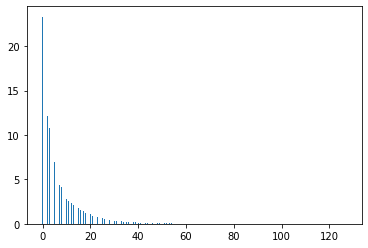

In [4]:
from classifiers.quantum.ansatz import Circuit9
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap

M=128
C=100
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
X, y = ds.data, ds.target
X, y = ds.sample(M, return_X_y=True)
ind = np.argsort(y)
X, y = X[ind], y[ind]
X = X[:, :]


feature_map1 = Circuit9(X.shape[1], reps=1)
feature_map = feature_map1.copy()
for _ in range(2 - 1):
    feature_map.compose(feature_map1, inplace=True)

#feature_map = ZZFeatureMap(4, 2, entanglement='linear')
gamma = 0.9
def RBF(x, y):
    return np.exp(-np.linalg.norm(x-y)**2/2/gamma)

def make_kmatrix(X, Y, f):
    ret = []
    for x in X:
        tmp = []
        for y in Y:
            tmp.append(f(x, y))
        ret.append(tmp)
    return np.matrix(ret)

quantum_instance = QuantumInstance(backend=AerSimulator(method='statevector'), shots=2**13)
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance, enforce_psd=True)
kernel_matrix = quantum_kernel.evaluate(x_vec=X)
# kernel_matrix =  make_kmatrix(X, X, RBF)
eigs = np.abs(np.linalg.eigvals(kernel_matrix))
plt.bar(np.arange(M), sorted(eigs, key=lambda x: -x), 0.3)

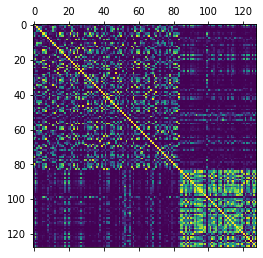

In [5]:
plt.matshow(kernel_matrix)

1.0


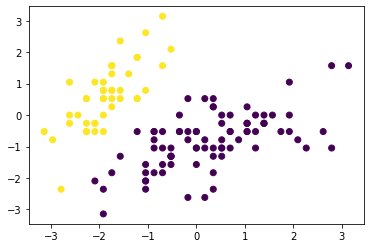

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(C=C, kernel='precomputed')
svm.fit(kernel_matrix, y)
c = svm.predict(kernel_matrix)#svm.decision_function(kernel_matrix)[0]
print(accuracy_score(y, svm.predict(kernel_matrix)))
plt.scatter(X[:,0], X[:, 1], c=c)
#plt.colorbar()

In [7]:
from cvxopt import matrix, solvers
M = kernel_matrix.shape[0]
P = matrix(kernel_matrix+np.eye(M)/C)
q = matrix(np.zeros(M))
G = matrix(-np.eye(M))
h = matrix(np.zeros(M))
A = matrix(np.ones(M), (1, M))
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)
alpha = np.array(sol['x']).flatten()
dval = alpha @ kernel_matrix @ alpha.reshape(-1, 1)
dval = dval.item()

sv_mask = np.where(alpha>=0.1*np.mean(alpha), True, False)

     pcost       dcost       gap    pres   dres
 0:  5.5112e-02 -9.6975e-01  1e+02  1e+01  1e+01
 1:  6.4018e-02 -9.4781e-01  2e+00  1e-01  1e-01
 2:  6.9167e-02 -2.5598e-01  3e-01  3e-16  4e-15
 3:  6.5894e-02 -5.8170e-05  7e-02  5e-16  2e-15
 4:  5.9327e-02  3.7658e-02  2e-02  1e-16  3e-16
 5:  5.5899e-02  4.8888e-02  7e-03  2e-16  2e-16
 6:  5.4047e-02  5.2031e-02  2e-03  8e-17  2e-16
 7:  5.3271e-02  5.2760e-02  5e-04  2e-16  2e-16
 8:  5.2995e-02  5.2972e-02  2e-05  5e-17  3e-16
 9:  5.2979e-02  5.2978e-02  9e-07  2e-16  2e-16
10:  5.2978e-02  5.2978e-02  4e-08  2e-16  2e-16
Optimal solution found.


In [8]:
def Rsquare(x):
    return dval-2*(alpha @ quantum_kernel.evaluate(X, x))+1

Rsquare_data = Rsquare(X)
R2 = np.mean(Rsquare_data[sv_mask]-2*alpha[sv_mask]/C)
sv_mask = np.where(Rsquare_data>=R2*1.002, True, False)

X_inside = X[~sv_mask]
X_outside = X[sv_mask]

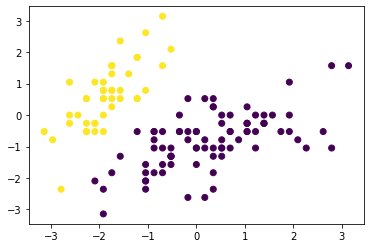

In [9]:
plt.scatter(X_inside[:, 0], X_inside[:, 1], c=y[~sv_mask])
plt.scatter(X_outside[:, 0], X_outside[:, 1], marker='o', edgecolors='k', color='none', s=100)

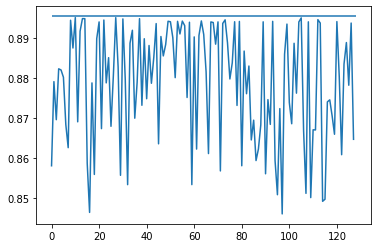

In [10]:
plt.plot(Rsquare_data)
plt.hlines(R2*1.002, 0, M)

In [11]:
A = np.eye(M)
inside_index = np.where(~sv_mask)[0]#np.where(~sv_mask)[0]
from itertools import product
from tqdm import tqdm
for i, j in tqdm(list(product(inside_index, inside_index))):
    if i>j:
        tX = np.asanyarray([t*X[i]+(1-t)*X[j] for t in np.linspace(0, 1, 20)])
        ind = Rsquare(tX)
        if np.any(ind>R2*1.002):
            A[i, j]=0
            A[j, i]=0
        else:
            A[i, j]=1
            A[j, i]=1
    else:
        continue

100%|██████████| 16384/16384 [3:58:45<00:00,  1.14it/s]  


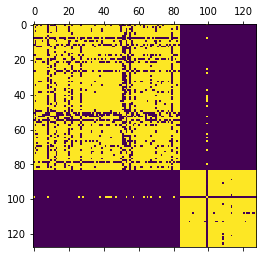

In [12]:
plt.matshow(A)

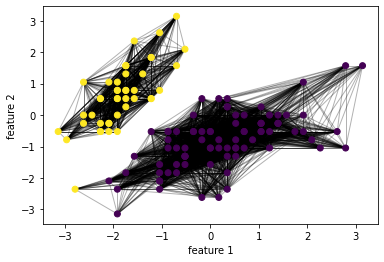

In [13]:
import networkx as nx 
G = nx.from_numpy_matrix(A)
positions = dict(zip(G.nodes, X[:, :2]))

ax = plt.subplot(1, 1, 1)
nx.draw_networkx_edges(G, positions, ax=ax, alpha=0.3)
ax.scatter(X_inside[:, 0], X_inside[:, 1], c=np.where(y[~sv_mask]==0, 0, 1))
ax.scatter(X_outside[:, 0], X_outside[:, 1], c=np.where(y[sv_mask]==0, 0, 1), marker='x')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
plt.savefig('./figs/quantum_clustering_result.png', dpi=200)

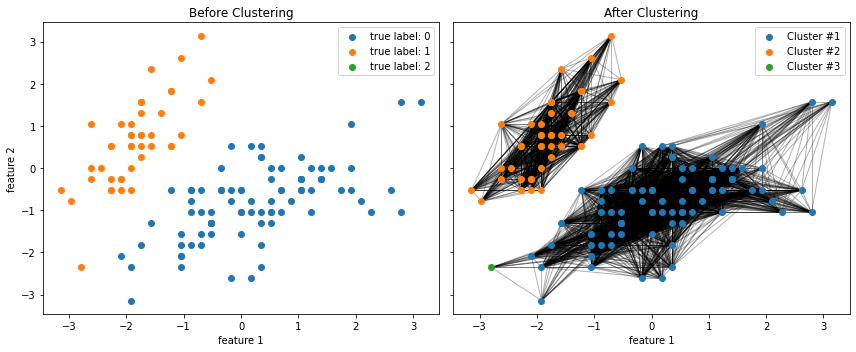

In [14]:
from networkx.algorithms.community import kernighan_lin_bisection, girvan_newman
G = nx.from_numpy_matrix(A)
positions = dict(zip(G.nodes, X[:, :2]))

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 5))
ax = axes[0]
ax.scatter(X[y==0, 0], X[y==0, 1], label='true label: 0')
ax.scatter(X[y==1, 0], X[y==1, 1], label='true label: 1')
ax.scatter(X[y==2, 0], X[y==2, 1], label='true label: 2')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.legend()
ax.set_title('Before Clustering')

ax = axes[1]
nx.draw_networkx_edges(G, positions, ax=ax, alpha=0.3)

graph_gen = girvan_newman(G)
top_community = next(graph_gen)
for i, subG in enumerate(top_community):
    clust = X[list(subG)]
    if i<3:
        ax.scatter(clust[:, 0], clust[:, 1], label=f'Cluster #{i+1}')
    else:
        ax.scatter(clust[:, 0], clust[:, 1])


#ax.scatter(X_inside[:, 0], X_inside[:, 1], c=np.where(y[~sv_mask]==0, 0, 1))
#ax.scatter(X_outside[:, 0], X_outside[:, 1], c=np.where(y[sv_mask]==0, 0, 1), marker='x')
ax.set_xlabel('feature 1')
ax.legend()
ax.set_title('After Clustering')
plt.tight_layout()
plt.savefig('./figs/quantum_clustering_result.png', dpi=200)

In [15]:
np.where(y==0)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

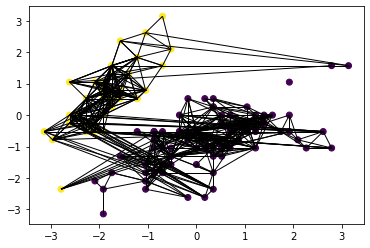

In [16]:
K2 = (kernel_matrix.flatten()>1-1/2*R2).reshape(M, M)
G = nx.from_numpy_matrix(K2)
positions = dict(zip(G.nodes, X[:, :2]))

ax = plt.subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=c)
nx.draw_networkx_edges(G, positions, ax=ax)

In [17]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, affinity='precomputed')
sc.fit(kernel_matrix)

SpectralClustering(affinity='precomputed', n_clusters=3)

In [18]:
sc.fit_predict(kernel_matrix)

array([0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0,
       2, 2, 2, 0, 2, 0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0,
       0, 1, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

0.078125


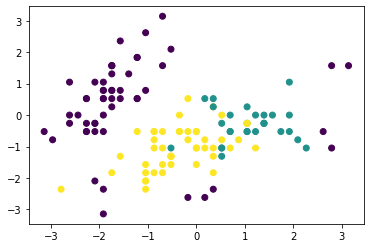

In [19]:
ax = plt.subplot(1, 1, 1)
sc_cluster_label = sc.fit_predict(kernel_matrix)
ax.scatter(X[:, 0], X[:, 1], c=sc_cluster_label)
print(min(sum(sc_cluster_label != y)/len(y), sum(sc_cluster_label == y)/len(y)))

In [20]:
refA = np.empty_like(kernel_matrix)
for i, j in list(product(range(M), range(M))):
    if i==j:
        refA[i, j]=1
    elif i>j:
        if y[i]!=y[j]:
            refA[i, j]=0
            refA[j, i]=0
        else:
            refA[i, j]=1
            refA[j, i]=1
    else:
        pass
refA

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

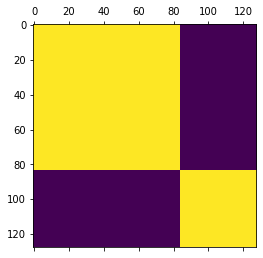

In [21]:
plt.matshow(refA)

In [22]:
def adj_error(mat, ref):
    return np.linalg.norm(mat-ref, ord=None)/np.linalg.norm(np.ones_like(ref), ord=None)